In [1]:
import numpy as np
import keras
from  keras.preprocessing.text import Tokenizer
import os
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import scikitplot
import seaborn as sns
from scikitplot.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score
from keras.utils import pad_sequences
from keras.models import Sequential, model_from_json
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout
import numpy as np 
import pandas as pd
import os

In [2]:
df_train = pd.read_csv('../input/emotions-dataset-for-nlp/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('../input/emotions-dataset-for-nlp/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('../input/emotions-dataset-for-nlp/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [3]:
df_train

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df_train.Sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

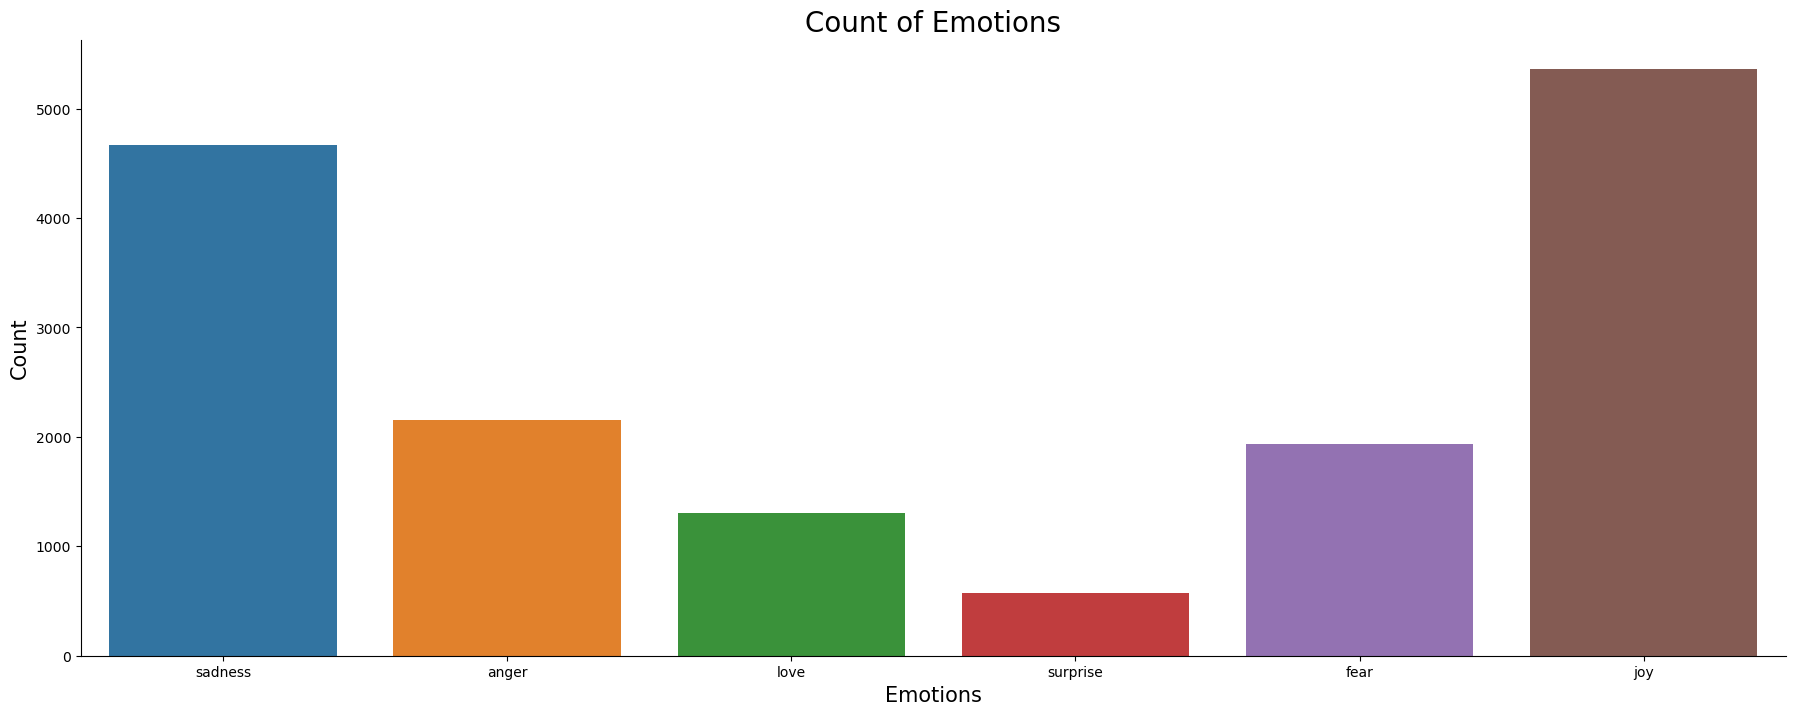

In [5]:
plt.figure(figsize=(22,8))
sns.countplot(x=df_train.Sentiment)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
X=df_train['Input']
lst=[]
for i in X:
    lst.append(len(i))
len1=pd.DataFrame(lst)
len1.describe()

,0
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [7]:
tokenizer=Tokenizer(15212,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X)

In [8]:
len(tokenizer.word_index)

15213

In [9]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='pre')

In [10]:
df_train['Sentiment']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
Y_train=df_train['Sentiment'].values

In [11]:
Y_train_f=to_categorical(Y_train)

In [12]:
X_val=df_val['Input']
Y_val=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='pre')
Y_val_f=to_categorical(Y_val)

In [13]:
model=Sequential()
model.add(Embedding(15212,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            973568    
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          92800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1926      
                                                                 
Total params: 1,479,174
Trainable params: 1,479,174
Non-

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 4,
                              restore_best_weights = True)

hist=model.fit(X_train_pad,Y_train_f,epochs=8,validation_data=(X_val_pad,Y_val_f), callbacks=[rlrp,earlystopping])

Epoch 1/8
500/500 [==============================] - 52s 72ms/step - loss: 1.2623 - accuracy: 0.5098 - val_loss: 0.7012 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 2/8
500/500 [==============================] - 13s 26ms/step - loss: 0.5024 - accuracy: 0.8226 - val_loss: 0.2943 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 3/8
500/500 [==============================] - 12s 24ms/step - loss: 0.2599 - accuracy: 0.9089 - val_loss: 0.1999 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 4/8
500/500 [==============================] - 11s 22ms/step - loss: 0.1949 - accuracy: 0.9301 - val_loss: 0.1811 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 5/8
500/500 [==============================] - 11s 22ms/step - loss: 0.1519 - accuracy: 0.9432 - val_loss: 0.1718 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 6/8
499/500 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9519
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 [==============================] - 11s 22

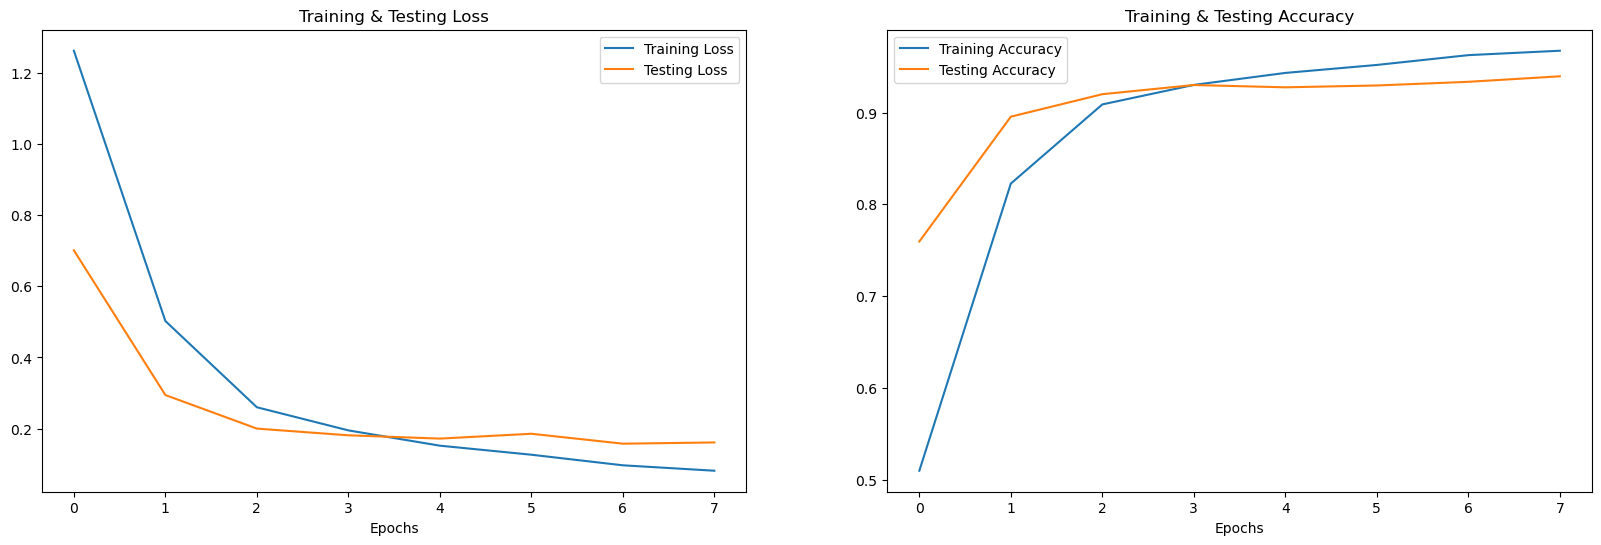

In [16]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [17]:
# Save model and weights
model_name = 'Emotion_Model_lstm_text_93.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Emotion_Model_lstm_text_93.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model_lstm_text_93.h5 


In [18]:
# loading json and model architecture 
json_file = open('/kaggle/input/emotion-by-text-models/Emotion_Model_bidirectional_text_93.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/kaggle/input/emotion-by-text-models/Emotion_Model_bidirectional_text_93.h5")
print("Loaded model from disk")
 
# Keras optimiser
loaded_model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Loaded model from disk


In [19]:
X_test=df_test['Input']
Y_test=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [20]:
X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='pre')
Y_test_f=to_categorical(Y_test)

In [21]:
X_test_pad.shape

(2000, 80)

In [22]:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 1s 11ms/step - loss: 0.1732 - accuracy: 0.9255


[0.17321714758872986, 0.9254999756813049]

In [23]:
Y_pred=np.argmax(model.predict(X_test_pad),axis=1)

63/63 [==============================] - 2s 9ms/step


Accuracy of our model on test data based on emotions:  93.0 %


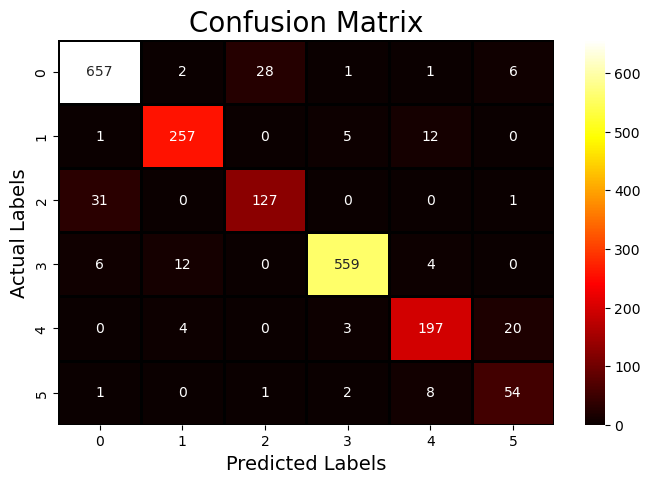

In [24]:
c = confusion_matrix(Y_test,Y_pred)
print("Accuracy of our model on test data based on emotions: " ,round(accuracy_score(Y_test,Y_pred),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in range(6)] , columns = [i for i in range(6)])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       695
           1       0.93      0.93      0.93       275
           2       0.81      0.80      0.81       159
           3       0.98      0.96      0.97       581
           4       0.89      0.88      0.88       224
           5       0.67      0.82      0.73        66

    accuracy                           0.93      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [26]:
def predict(sentence):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=80,padding='post')
    ans = np.argmax(loaded_model.predict(sentence_padded),axis=1)
    for key,val in dictionary.items():
        if (val==ans):
            print("The emotion predicted is",key)

In [27]:
predict(str("There are many elements in life that we find the most joy in. Some of the elements that bring me the most joy are spending time with my family, friends and helping others mostly children. The gifts and talents I have are a source of my joy. Some of those gifts and talents include my musical ability and natural connection with children."))

1/1 [==============================] - 1s 1s/step
The emotion predicted is joy


In [28]:
predict(str("I let out a sigh of frustration as I seethed in anger. When I had lent my dress to Natalia I had specifically told her to take good care of it as I hadn’t yet had a chance to wear it. It seemed that my sister hadn’t bothered about my instructions at all. If she had been standing there I would’ve wanted to shake some sense into her."))

1/1 [==============================] - 0s 28ms/step
The emotion predicted is anger


In [29]:
predict(str("i scared from ghosts"))

1/1 [==============================] - 0s 27ms/step
The emotion predicted is fear
